In [56]:
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score, fbeta_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, confusion_matrix
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

import shap
from pathlib import Path
from sklearn.preprocessing import FunctionTransformer

from catboost import CatBoostClassifier, Pool

In [57]:
# QuickView
class QuickView:
    def __init__(self, df, target=None, max_unique=10):
        # Сохраняем входные параметры (поведение исходных функций не меняем)
        self.df = df
        self.target = target
        self.max_unique = max_unique

    def quick_overview(self):
        # --- Общий обзор: внешний вид, размер, типы, пропуски, дубликаты, баланс таргета ---
        df = self.df
        target = self.target
        print("Внешний вид:", df.head().T)
        print("Размер:", df.shape)
        print("\nТипы данных:\n", df.dtypes)
        print("\nПропуски (шт):\n", df.isnull().sum())
        dup = df.duplicated().sum()
        print(f"\nДубликатов: {dup} ({dup / len(df) * 100:.2f}%)")
        if target and target in df.columns:
            print("\nБаланс таргета:")
            print(df[target].value_counts(normalize=True))

    def quick_details(self):
        # --- Детали: describe, min/max, частоты категориальных/низко-кардинальных, уникальные значения ---
        df = self.df
        target = self.target
        max_unique = self.max_unique

        print("\n--- Статистика числовых признаков ---")
        print(df.describe())

        print("\n--- Min/Max по числовым ---")
        desc = df.describe()
        print(desc.loc[['min', 'max']] if 'min' in desc.index else desc[['min', 'max']])

        print("\n--- Частоты категориальных ---")
        for col in df.columns:
            if df[col].dtype == 'object' or df[col].nunique() <= max_unique:
                # Частоты значений (включая NaN)
                print(f"\nЧастоты в '{col}':")
                print(df[col].value_counts(dropna=False))

        if target and target in df.columns:
            # Корреляции числовых признаков с таргетом (ожидается числовой таргет)
            print("\n--- Корреляции с таргетом ---")
            print(df.corr(numeric_only=True)[target].sort_values(ascending=False))

    def quick_plots(self, bins=50, ncols=3):
        # Гистограммы только по числовым колонкам с управляемой сеткой
        num_cols = self.df.select_dtypes(include="number").columns
        n = len(num_cols)
        if n == 0:
            print("Нет числовых столбцов для гистограмм.")
            return
        nrows = (n + ncols - 1) // ncols

        axes = self.df[num_cols].hist(
            bins=bins,
            figsize=(3.8 * ncols, 3.0 * nrows),
            layout=(nrows, ncols),
            sharex=False, sharey=False,
            grid=False
        )

        # Выравниваем подписи и заголовки, чтобы не наслаивались
        for ax in axes.ravel():
            if ax is None:  # на всякий случай, если сетка больше числа графиков
                continue
            ax.tick_params(axis='x', labelrotation=30, labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            ax.set_title(ax.get_title(), fontsize=9, pad=4)

        plt.tight_layout()
        plt.show()

    def quick_boxplots(self, cols=None, ncols=3):
        y = self.target
        if not y or y not in self.df.columns: print("Укажи корректный target"); return
        base = self.df.drop(columns=['id', 'Unnamed: 0', 'Unnamed:0'], errors='ignore')
        cols = cols or [c for c in base.select_dtypes(include="number").columns if c != y]
        nrows = (len(cols) + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(3.2 * ncols, 2.4 * nrows), squeeze=False)
        for ax, c in zip(axes.ravel(), cols):
            base.boxplot(column=c, by=y, ax=ax)
            ax.set_title(c)
            ax.set_xlabel(y)
        for ax in axes.ravel()[len(cols):]: ax.set_visible(False)
        plt.suptitle("")
        fig.tight_layout()
        plt.show()

    def report(self):
        # --- Полный отчёт ---
        self.quick_overview()
        self.quick_details()
        self.quick_plots()
        self.quick_boxplots()

In [58]:
class EDAAnalyzer:
    def __init__(self, df, target_col=None):
        self.df = df.copy()
        self.target_col = target_col

        # 0) удалить служебные
        drop_cols = [c for c in self.df.columns if c.lower() in ('unnamed: 0', 'unnamed:0', 'id')]
        self.df.drop(columns=drop_cols, errors='ignore', inplace=True)

        # 1) Gender: восстановить и зафиксировать 0/1 (защитим от дальнейших кастов)
        # 1) Gender: восстановить и зафиксировать 0/1 (защитим от дальнейших кастов)
        if 'Gender' in self.df.columns:
            g = (self.df['Gender'].astype('string').str.strip()
                 .str.replace(r'\.0$', '', regex=True).str.lower())
            # Используем более современный подход без deprecated replace behavior
            gender_map = {'male': 1, 'female': 0, '1': 1, '0': 0}
            self.df['Gender'] = g.map(gender_map).fillna(g).astype('Int8')

        self._protect = {'Gender'}  # не трогать в cast_dtypes

        # 2) Если есть BMI и Obesity — оставить только BMI (избежать дублирования смысла)
        if {'BMI', 'Obesity'} <= set(self.df.columns):
            self.df.drop(columns=['Obesity'], inplace=True)

        # 3) Базовые «правильные» типы (минимально и по именам)
        if 'Diet' in self.df.columns:
            self.df['Diet'] = self.df['Diet'].astype('Int16').astype('category')
        if 'Stress Level' in self.df.columns:
            self.df['Stress Level'] = pd.to_numeric(self.df['Stress Level'], errors='coerce').round().astype('Int16')
        if 'Physical Activity Days Per Week' in self.df.columns:
            self.df['Physical Activity Days Per Week'] = (
                pd.to_numeric(self.df['Physical Activity Days Per Week'], errors='coerce').round().astype('Int16')
            )

    def missing_values(self):
        # нормализация текстовых пропусков
        self.df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

        # колонны «блока» (те самые 9)
        block_cols = [
            'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption',
            'Previous Heart Problems', 'Medication Use', 'Stress Level',
            'Physical Activity Days Per Week'
        ]
        present = [c for c in block_cols if c in self.df.columns]

        # скрытые маркеры пропусков: если встречается одно «особое» значение ровно столько же раз,
        # сколько NaN в "блоке" — заменяем его на NaN (без создания *_missing по каждой колонке)
        if present:
            # частоты NaN по блоку
            blk_na = self.df[present].isna().sum()
            if (blk_na.nunique() == 1) and (blk_na.iloc[0] > 0):
                n = int(blk_na.iloc[0])
                for c in [x for x in self.df.columns if x not in present]:
                    vc = self.df[c].value_counts(dropna=False)
                    for val, cnt in vc.items():
                        if pd.isna(val) or cnt != n: continue
                        m = (self.df[c] == val)
                        # строго совпадаем со строками блока: все present = NaN
                        if (self.df.loc[m, present].isna().all(axis=1)).all():
                            self.df.loc[m, c] = pd.NA

            # единый флаг блока
            block_mask = self.df[present].isna().all(axis=1)
            if block_mask.any():
                self.df['block_missing'] = block_mask.astype('Int8')

    def cast_dtypes(self):
        for c in self.df.columns:
            if c == self.target_col or c in self._protect:
                continue
            s = self.df[c]

            # object → попытка бинаризации, иначе category
            if pd.api.types.is_object_dtype(s):
                u = s.astype('string').str.strip().str.lower()
                t = pd.to_numeric(u.replace({'true': '1', 'false': '0', 'yes': '1', 'no': '0'}), errors='coerce')
                if t.dropna().isin([0, 1]).all():
                    self.df[c] = t.astype('Int8')
                else:
                    self.df[c] = u.astype('category')
                continue

            # НЕ перекастим уже целочисленные и категориальные обратно во float
            if s.dtype.kind in 'iu' or isinstance(s.dtype, pd.CategoricalDtype):
                continue

            # остальное в числовое
            self.df[c] = pd.to_numeric(s, errors='coerce')

    def impute_minimal(self):
        # Числовые → медиана; Stress Level уже целочисленный — переимпутируем медианой; Diet → "Unknown"
        num_cols = [c for c in self.df.columns
                    if (c != self.target_col) and pd.api.types.is_numeric_dtype(self.df[c])]
        for c in num_cols:
            if self.df[c].isna().any():
                med = self.df[c].median()
                # для ординальных целых — округлим после заполнения
                self.df[c] = self.df[c].fillna(med)
                if pd.api.types.is_integer_dtype(self.df[c]):  # Int16/Int8 уже ок
                    continue
        if 'Stress Level' in self.df.columns and self.df['Stress Level'].isna().any():
            med = int(round(self.df['Stress Level'].median()))
            self.df['Stress Level'] = self.df['Stress Level'].fillna(med).astype('Int16')
        if 'Diet' in self.df.columns:
            if self.df['Diet'].isna().any():
                self.df['Diet'] = self.df['Diet'].cat.add_categories(['Unknown']).fillna('Unknown')

    # Короткий отчёт (оставил только самое нужное)
    def report(self):
        print(f"Размер: {self.df.shape}")
        if self.target_col in self.df.columns:
            print("Баланс таргета:\n", self.df[self.target_col].value_counts(normalize=True))
        self.missing_values()
        self.cast_dtypes()
        self.impute_minimal()
        print("Колонки:", list(self.df.columns))
        print("Dtypes:\n", self.df.dtypes)
        if self.target_col in self.df.columns:
            print("\nКорр с таргетом (числовые):")
            print(self.df.corr(numeric_only=True)[self.target_col].sort_values(ascending=False))

    def process(self):
        """Обрабатывает данные и возвращает очищенный DataFrame"""
        self.missing_values()
        self.cast_dtypes()
        self.impute_minimal()
        return self.df


In [59]:
# === Настройки путей ===
DATA_DIR = Path.cwd().parent / "data"

TRAIN_PATH = DATA_DIR / "heart_train.csv"
TEST_PATH = DATA_DIR / "heart_test.csv"
TARGET = "Heart Attack Risk (Binary)"

# === Загрузка данных ===
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

Внешний вид:                                         0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.359551  0.202247  0.606742  0.730337   
Cholesterol                      0.732143     0.325  0.860714  0.007143   
Heart rate                       0.074244  0.047663  0.055912  0.053162   
Diabetes                              1.0       1.0       1.0       0.0   
Family History                        1.0       1.0       0.0       0.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       0.0       1.0       0.0   
Alcohol Consumption                   1.0       1.0       1.0       1.0   
Exercise Hours Per Week          0.535505   0.06869  0.944001  0.697023   
Diet                                    1         2         2         0   
Previous Heart Problems               1.0       1.0       1.0       0.0   
Medication U

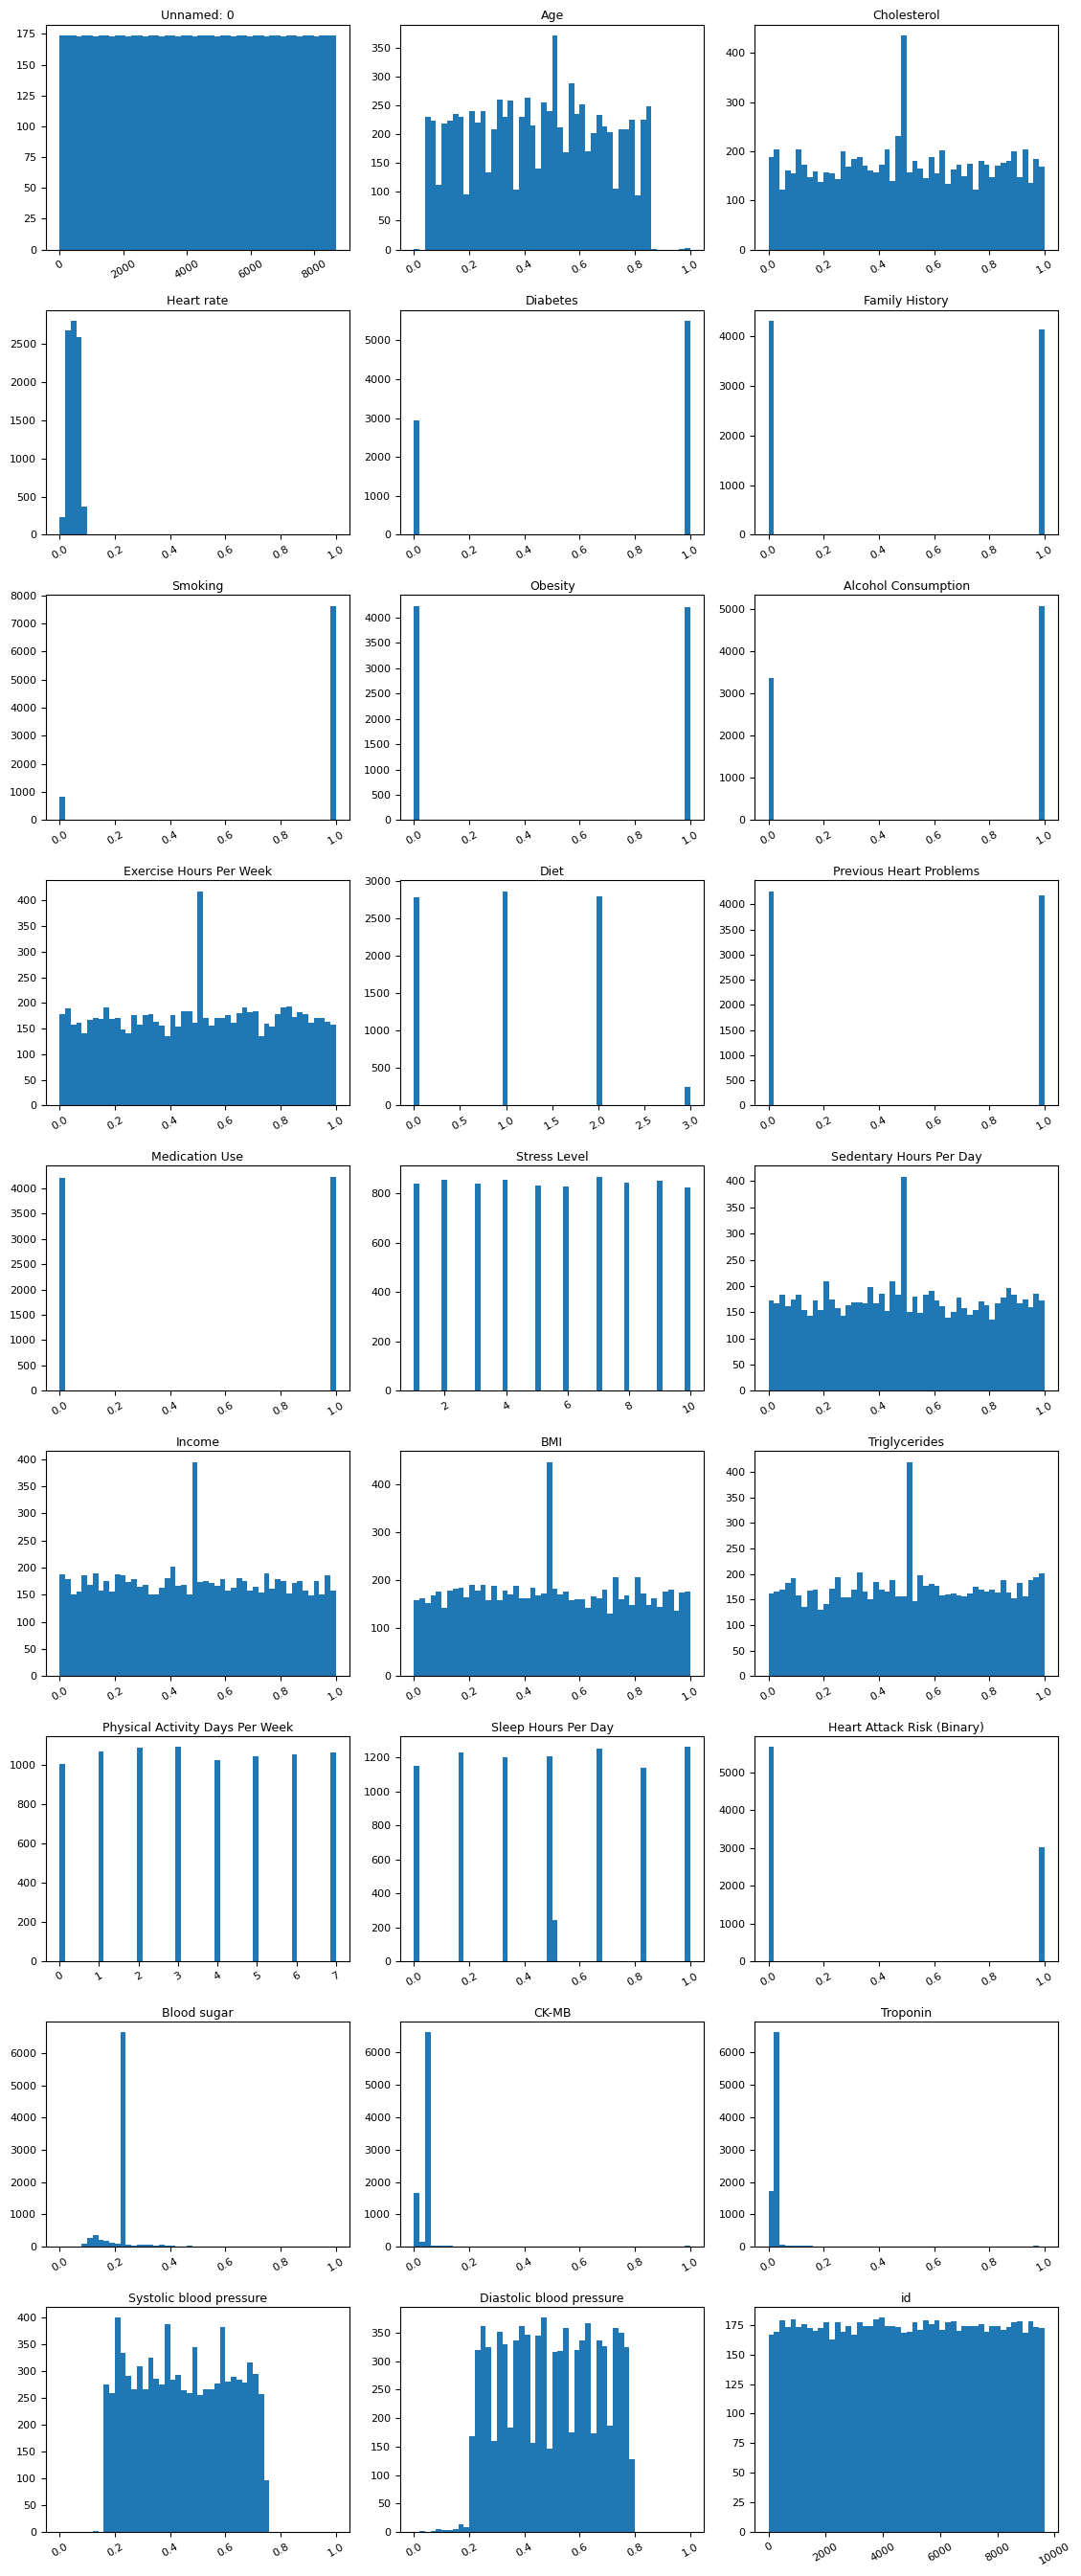

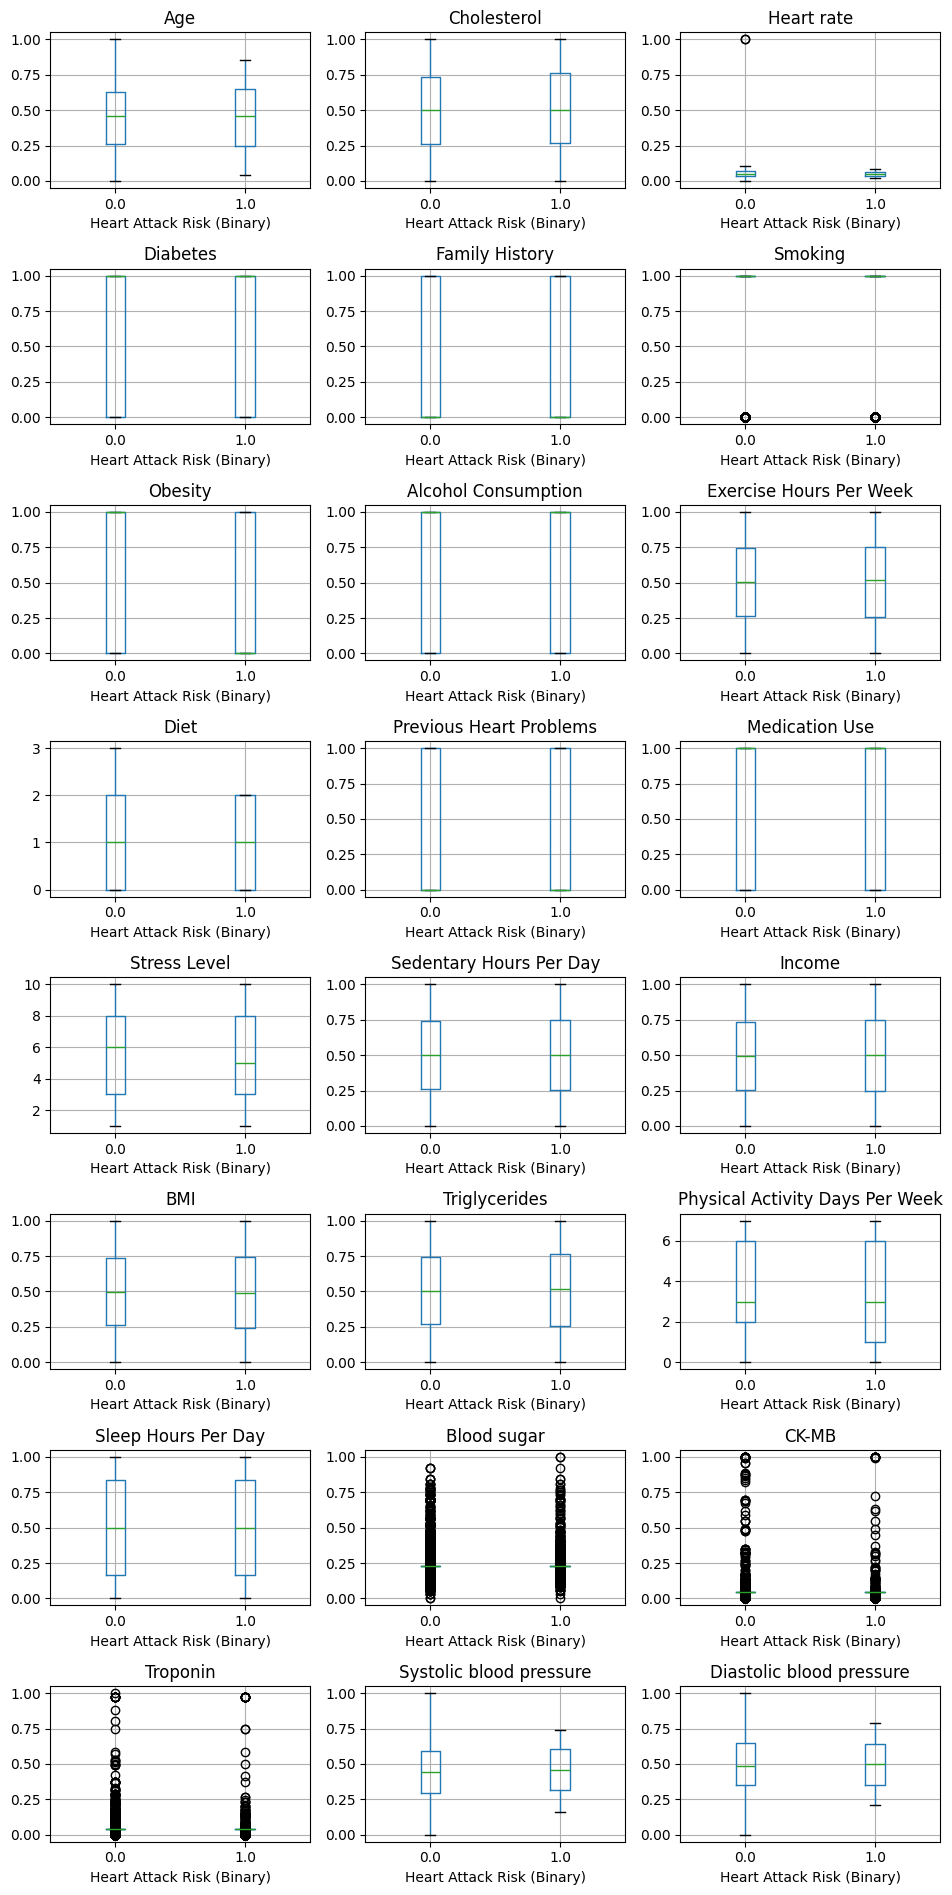

In [60]:
# === Быстрый обзор train ===
preEDA = QuickView(train_df, target="Heart Attack Risk (Binary)").report()


Внешний вид:                                         0         1         2         3  \
Unnamed: 0                              0         1         2         3   
Age                              0.494382  0.224719  0.629213  0.460674   
Cholesterol                      0.264286  0.953571  0.092857  0.567857   
Heart rate                       0.062328  0.082493  0.064161  0.055912   
Diabetes                              0.0       1.0       0.0       1.0   
Family History                        1.0       0.0       1.0       1.0   
Smoking                               1.0       0.0       1.0       1.0   
Obesity                               1.0       1.0       1.0       1.0   
Alcohol Consumption                   1.0       0.0       0.0       1.0   
Exercise Hours Per Week          0.361618  0.996483  0.995561  0.437277   
Diet                                    2         2         0         0   
Previous Heart Problems               0.0       1.0       0.0       0.0   
Medication U

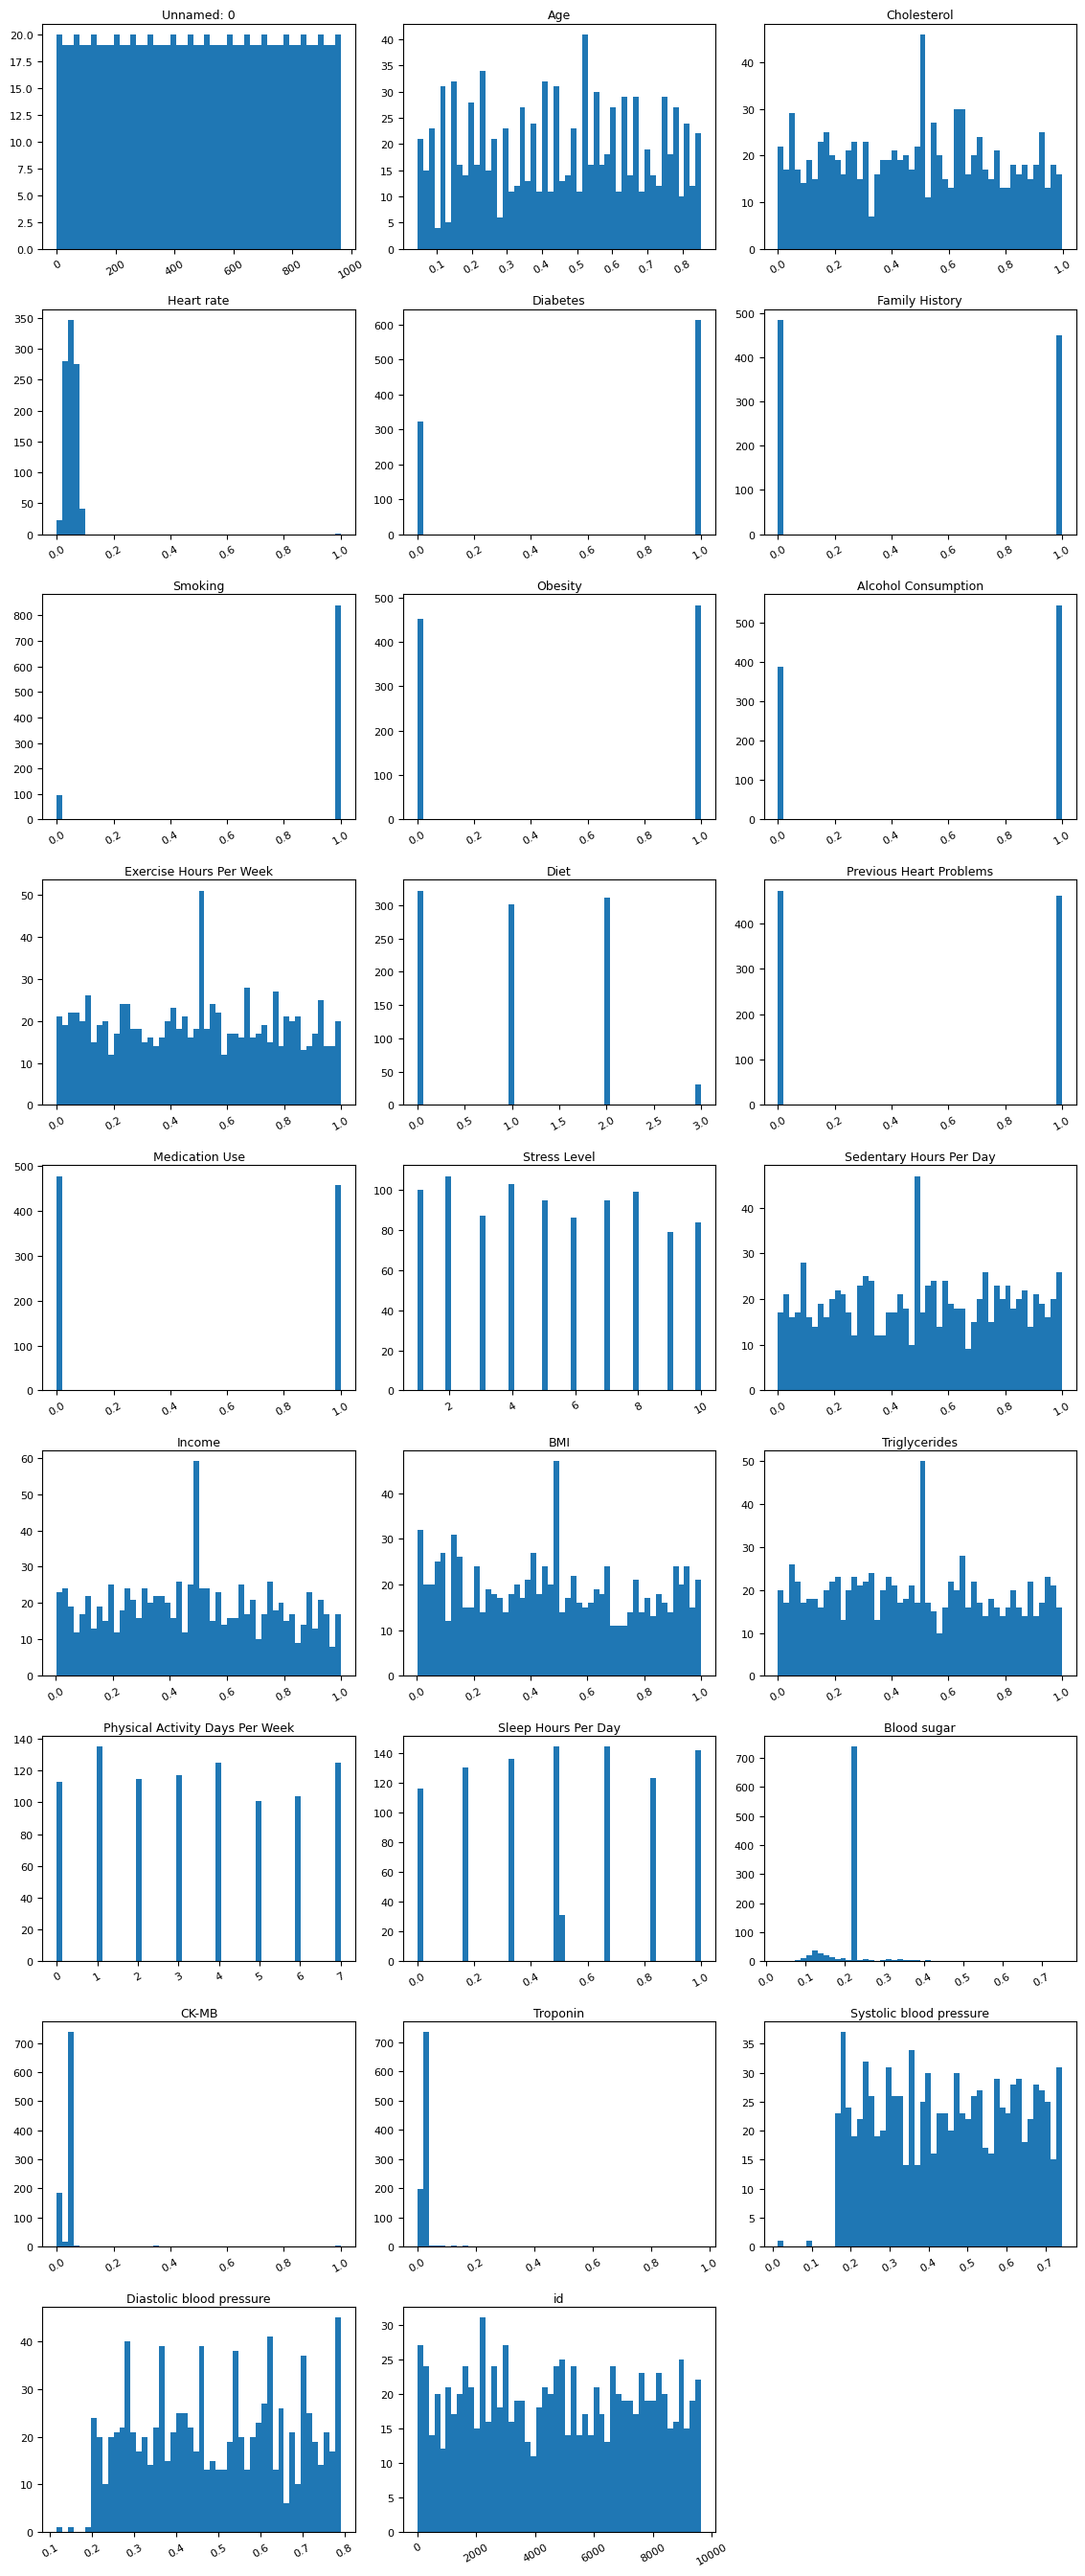

Укажи корректный target


In [61]:
# === Быстрый обзор test (без таргета) ===
QuickView(test_df, target="Heart Attack Risk (Binary)").report()

In [62]:
# EDA анализ
e = EDAAnalyzer(train_df, target_col="Heart Attack Risk (Binary)")
e.report()

Размер: (8685, 25)
Баланс таргета:
 Heart Attack Risk (Binary)
0.0    0.65308
1.0    0.34692
Name: proportion, dtype: float64
Колонки: ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure', 'block_missing']
Dtypes:
 Age                                 float64
Cholesterol                         float64
Heart rate                          float64
Diabetes                            float64
Family History                      float64
Smoking                             float64
Alcohol Consumption                 float64
Exercise Hours Per Week             float64
Diet                               categ

In [63]:
e.df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,block_missing
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,0.535505,1,1.0,...,3,0.333333,0.0,0.227018,0.048229,0.036512,1,0.212903,0.709302,0
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,1.0,0.068690,2,1.0,...,3,0.833333,0.0,0.150198,0.017616,0.000194,0,0.412903,0.569767,0
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,0.944001,2,1.0,...,2,1.000000,0.0,0.227018,0.048229,0.036512,0,0.238710,0.220930,0
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,1.0,0.697023,0,0.0,...,0,0.333333,1.0,0.227018,0.048229,0.036512,0,0.348387,0.267442,0
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,1.0,0.412878,1,0.0,...,5,1.000000,1.0,0.227018,0.048229,0.036512,1,0.619355,0.441860,0


Внешний вид:                                         0         1         2         3  \
Age                              0.359551  0.202247  0.606742  0.730337   
Cholesterol                      0.732143     0.325  0.860714  0.007143   
Heart rate                       0.074244  0.047663  0.055912  0.053162   
Diabetes                              1.0       1.0       1.0       0.0   
Family History                        1.0       1.0       0.0       0.0   
Smoking                               1.0       0.0       1.0       1.0   
Alcohol Consumption                   1.0       1.0       1.0       1.0   
Exercise Hours Per Week          0.535505   0.06869  0.944001  0.697023   
Diet                                    1         2         2         0   
Previous Heart Problems               1.0       1.0       1.0       0.0   
Medication Use                        0.0       0.0       1.0       1.0   
Stress Level                            8         9         6         3   
Sedentary Ho

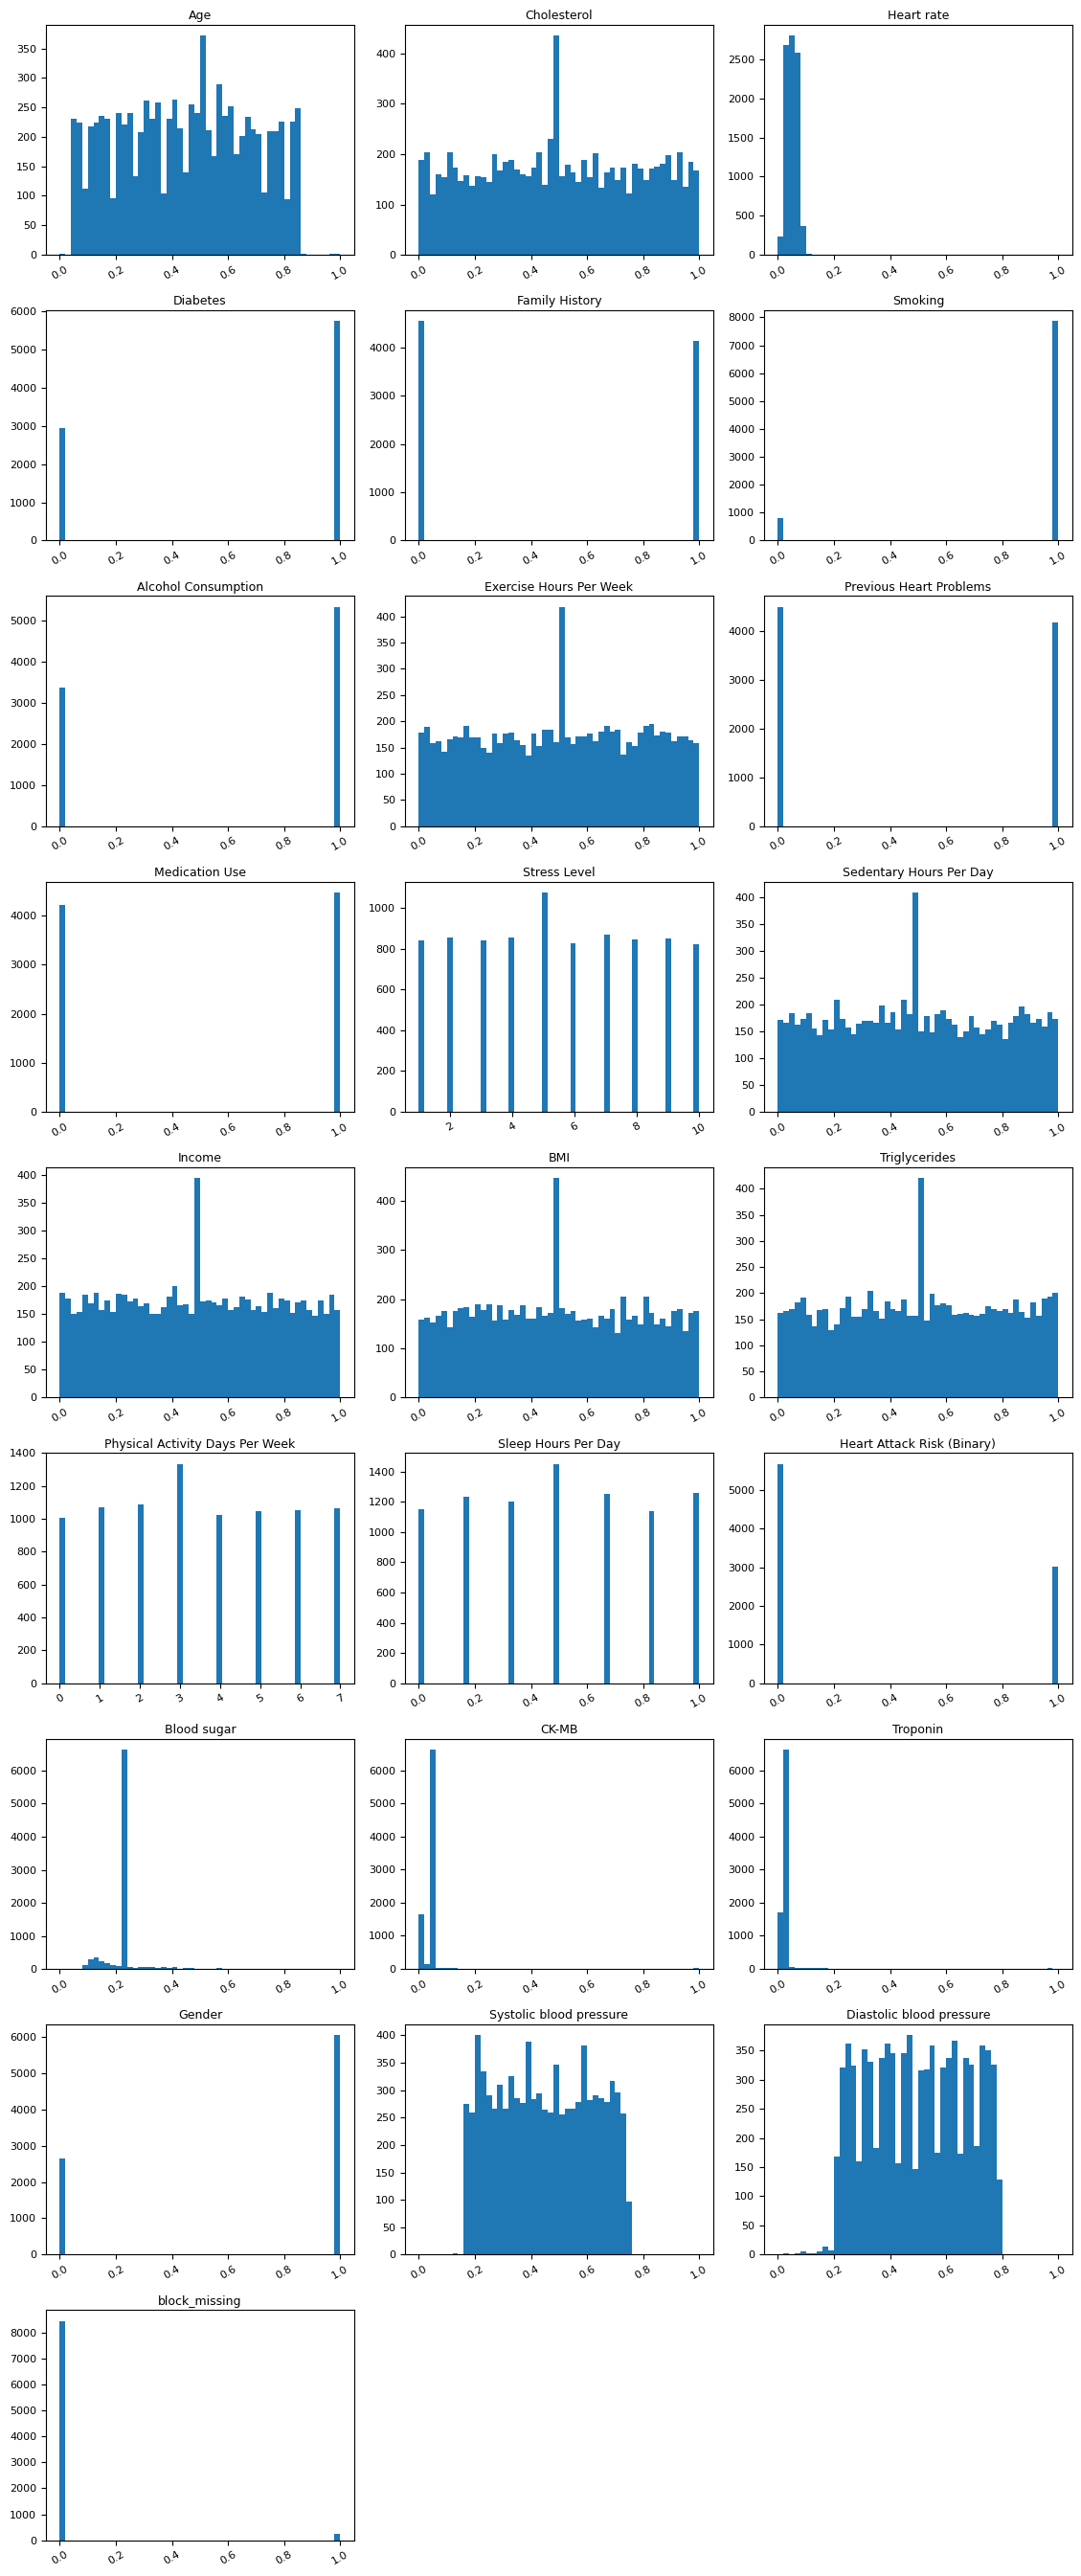

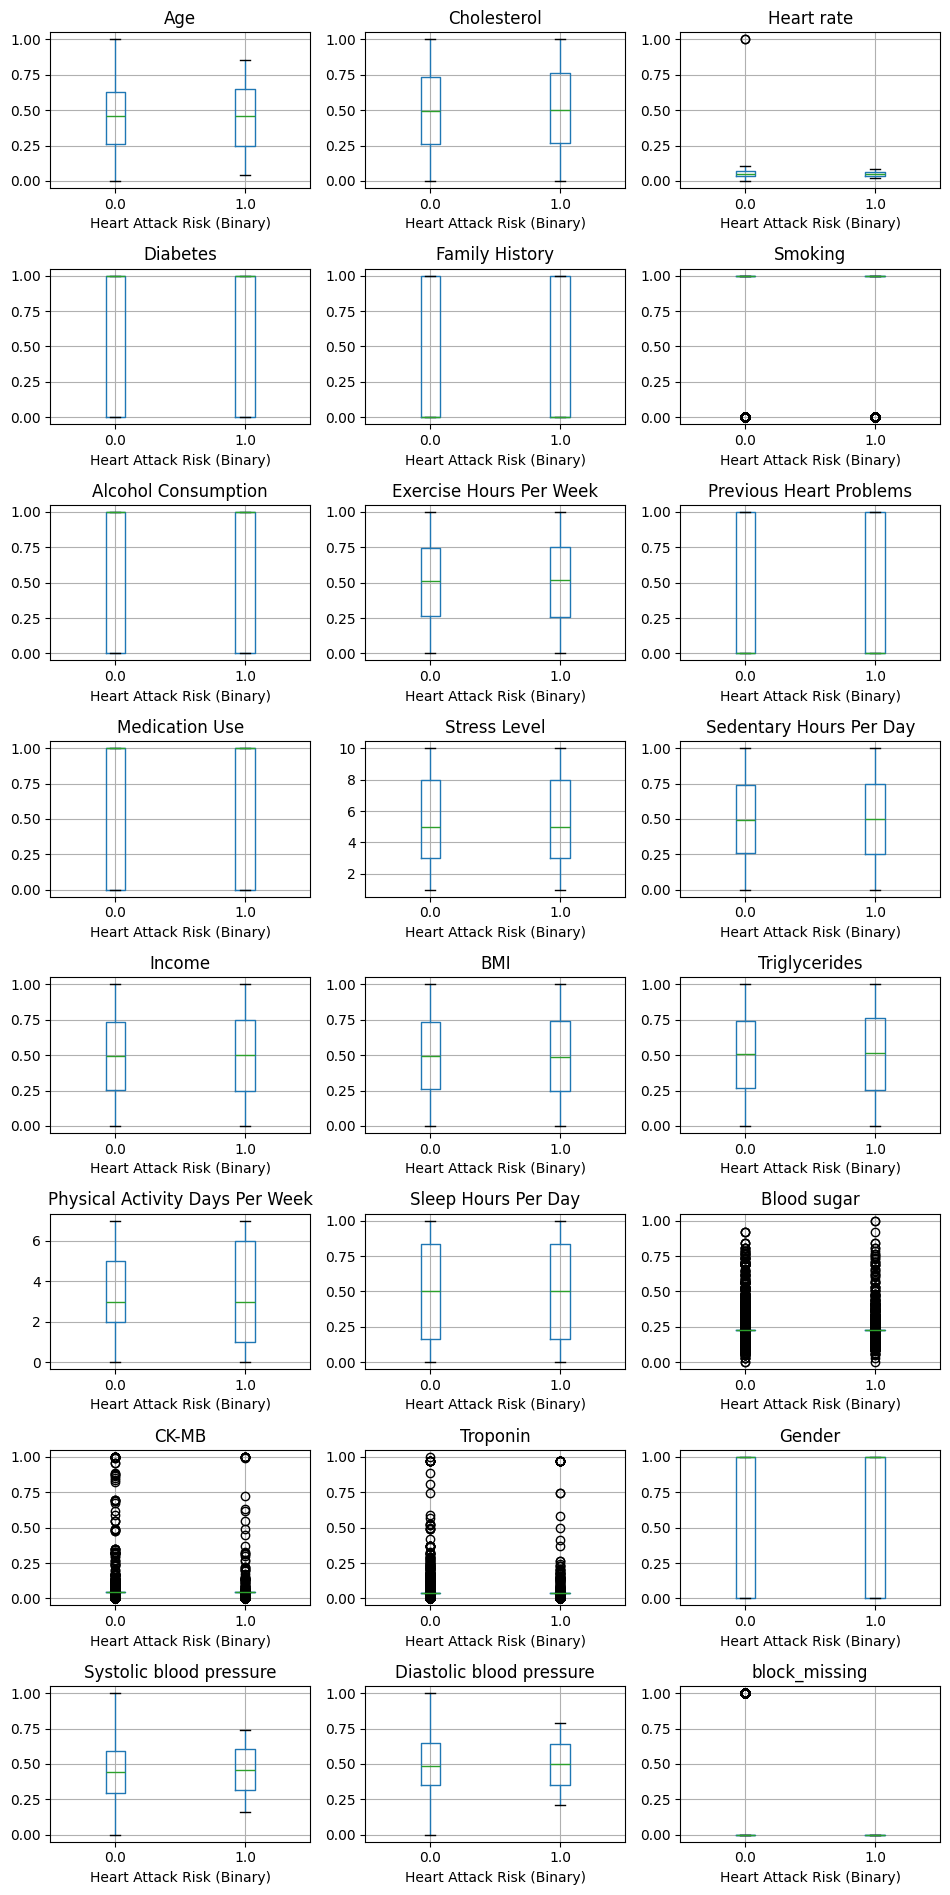

In [64]:
postEDA = QuickView(e.df, target="Heart Attack Risk (Binary)").report()

In [65]:
# --- Константы ---
TARGET = "Heart Attack Risk (Binary)"
LEAKS = ['Troponin', 'CK-MB', 'Previous Heart Problems', 'Medication Use']
SEED, SPLITS, BETA, BOOT_N = 42, 3, 2.0, 100
rng = np.random.default_rng(SEED)
SHAP_N = 200  # сколько строк брать для SHAP

# 1) Подготовка через EDAAnalyzer
prep = EDAAnalyzer(train_df, target_col=TARGET).process()
y = pd.to_numeric(prep[TARGET], errors="coerce").round().astype(int)
X_full_all = prep.drop(columns=[TARGET])


# 2) Вспомогательное
def cat_cols(df): return [c for c in df.columns if str(df[c].dtype) in ("category", "object")]


def class_w(y):
    p = y.mean()
    return {0: 0.5 / (1 - p + 1e-12), 1: 0.5 / (p + 1e-12)}


def tune_thr_fbeta(y_true, p, beta=BETA, grid=np.linspace(0.01, 0.99, 99)):
    best_t, b = -1, -1
    for t in grid:
        s = fbeta_score(y_true, (p >= t).astype(int), beta=beta, zero_division=0)
        if s > b: b = s; best_t = t
    return float(best_t), float(b)


def metrics(y_true, p, thr, beta=BETA):
    pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred, labels=[0, 1]).ravel()
    return dict(
        F1=f1_score(y_true, pred, zero_division=0),
        F2=fbeta_score(y_true, pred, beta=beta, zero_division=0),
        ROC_AUC=roc_auc_score(y_true, p),
        PR_AUC=average_precision_score(y_true, p),
        Precision=precision_score(y_true, pred, zero_division=0),
        Recall=recall_score(y_true, pred, zero_division=0),
        TN=int(tn), FP=int(fp), FN=int(fn), TP=int(tp),
        threshold=float(thr)
    )


def boot_ci(y_true, p, thr, metric, n=BOOT_N, seed=SEED, beta=BETA):
    rngl = np.random.default_rng(seed)
    y_true = np.asarray(y_true)
    p = np.asarray(p)
    N = len(y_true)
    vals = []
    for _ in range(n):
        idx = rngl.integers(0, N, size=N)
        yt = y_true[idx]
        pp = p[idx]
        if metric == "ROC_AUC":
            vals.append(roc_auc_score(yt, pp))
        elif metric == "PR_AUC":
            vals.append(average_precision_score(yt, pp))
        elif metric == "F1":
            vals.append(f1_score(yt, (pp >= thr).astype(int), zero_division=0))
        elif metric == "F2":
            vals.append(fbeta_score(yt, (pp >= thr).astype(int), beta=beta, zero_division=0))
    return float(np.percentile(vals, 2.5)), float(np.percentile(vals, 97.5))


# >>> кросс-версионный OHE (sklearn >=1.2 использует sparse_output)
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32)


# >>> безопасный препроцессор для категориальных (int/str -> str -> OHE) с корректными именами фич

def _to_str_matrix(X):
    # аккуратно приводим к строкам, сохраняя форму
    if isinstance(X, pd.DataFrame):
        return X.astype(str)
    X = np.asarray(X)
    return X.astype(str)


def make_cat_preproc(cats):
    to_str = FunctionTransformer(_to_str_matrix, validate=False, feature_names_out="one-to-one")
    return ColumnTransformer(
        [("cat", Pipeline([("to_str", to_str), ("ohe", make_ohe())]), cats)],
        remainder="passthrough",
        verbose_feature_names_out=False
    )


# >>> SHAP leakage report (минимальный отчёт)
def shap_leak_report(s: pd.Series, leaks: list[str], title: str):
    present = [f for f in leaks if f in s.index]
    print(f"\n[SHAP leakage check] {title}")
    if not present:
        print("  leak-фичи отсутствуют в модели.")
        return
    ranks = s.rank(ascending=False, method="min")
    tot = s.sum() if s.sum() != 0 else 1.0
    share = float(s[present].sum() / tot)
    for f in present:
        print(f"  {f}: rank={int(ranks[f])}, mean|SHAP|={s[f]:.6f}")
    print(f"  Суммарная доля leak-фичей в |SHAP|: {share * 100:.1f}%")


# >>> Нормализация формы SHAP до (n_samples, n_features)
def _shap_to_2d(shap_vals):
    """
    Привести вывод SHAP к форме (n_samples, n_features) для бинарной классификации.
    Работает для вариантов:
      - list из 2 массивов (по классам),
      - 3D (n_samples, n_classes, n_features),
      - 3D (n_samples, n_features, n_classes),
      - уже 2D (n_samples, n_features).
    """
    # 1) Список по классам -> берём класс 1 (positive) если есть, иначе 0
    if isinstance(shap_vals, list):
        arr = np.asarray(shap_vals[1] if len(shap_vals) > 1 else shap_vals[0])
    else:
        arr = np.asarray(shap_vals)

    # 2) 3D тензор -> определить ось классов и вырезать её
    if arr.ndim == 3:
        n_samples, a1, a2 = arr.shape
        # классическая форма (n_samples, n_classes, n_features)
        if a1 in (1, 2) and a2 not in (1, 2):
            arr = arr[:, 1 if a1 > 1 else 0, :]  # -> (n_samples, n_features)
        # альтернативная форма (n_samples, n_features, n_classes)
        elif a2 in (1, 2) and a1 not in (1, 2):
            arr = arr[:, :, 1 if a2 > 1 else 0]  # -> (n_samples, n_features)
        else:
            # Фолбэк: выбрать ось размером 2 как классовую, иначе последнюю
            class_axis = 2 if a2 in (1, 2) else (1 if a1 in (1, 2) else 2)
            sl = [slice(None)] * 3
            sl[class_axis] = 1
            arr = arr[tuple(sl)]  # -> (n_samples, n_features) при нормальном порядке

    # 3) На выходе хотим 2D
    if arr.ndim != 2:
        # Последняя попытка: если по ошибке оси перепутаны, попробуем "разогнуть" разумно
        arr = np.squeeze(arr)
        if arr.ndim != 2:
            raise ValueError(f"Unexpected SHAP shape after normalization: {arr.shape}")

    return arr


# 3) Модели
def make_cat():
    return CatBoostClassifier(
        depth=6, learning_rate=0.05, iterations=600,
        l2_leaf_reg=3.0, random_seed=SEED,
        loss_function="Logloss", eval_metric="AUC", verbose=False,
        use_best_model=True, od_type="Iter", od_wait=80
    )


def make_rf():  return RandomForestClassifier(n_estimators=500, class_weight="balanced", n_jobs=-1, random_state=SEED)


def make_hgb(): return HistGradientBoostingClassifier(learning_rate=0.05, max_iter=400, random_state=SEED)


# 4) Оценка модели с CV
def eval_cv(model_key, X, y, cats):
    skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=SEED)
    oof = np.zeros(len(X))
    fold_ms = []
    if model_key in ("rf", "hgb"):
        pre = make_cat_preproc(cats)
    for tr, va in skf.split(X, y):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]
        if model_key == "cat":
            m = make_cat()
            pos = ytr.sum()
            neg = len(ytr) - pos
            m.set_params(scale_pos_weight=(neg / (pos + 1e-12)))
            pool_tr = Pool(Xtr, label=ytr, cat_features=[X.columns.get_loc(c) for c in cats])
            pool_va = Pool(Xva, label=yva, cat_features=[X.columns.get_loc(c) for c in cats])
            m.fit(pool_tr, eval_set=pool_va, verbose=False)
            pr = m.predict_proba(pool_va)[:, 1]
        elif model_key == "rf":
            m = Pipeline([("pre", pre), ("clf", make_rf())])
            m.fit(Xtr, ytr)
            pr = m.predict_proba(Xva)[:, 1]
        else:  # hgb
            m = Pipeline([("pre", pre), ("clf", make_hgb())])
            sw = ytr.map(class_w(ytr)).values
            m.fit(Xtr, ytr, clf__sample_weight=sw)
            pr = m.predict_proba(Xva)[:, 1]
        thr, _ = tune_thr_fbeta(yva, pr)
        fold_ms.append(metrics(yva, pr, thr))
        oof[va] = pr
    thr_oof, _ = tune_thr_fbeta(y, oof)
    m_oof = metrics(y, oof, thr_oof)
    ci = {k: boot_ci(y, oof, thr_oof, k) for k in ("F2", "F1", "ROC_AUC", "PR_AUC")}
    return dict(oof=oof, thr=thr_oof, m=m_oof, ci=ci)


# 5) Прогоны: без утечек и с утечками; модели: CatBoost / HistGB / RF
scenarios = {
    "no_leak": [c for c in X_full_all.columns if c not in LEAKS],
    "with_leak": [c for c in X_full_all.columns]
}
models = {"cat": "CatBoost", "hgb": "HistGB", "rf": "RandomForest"}
results = []
for scen, cols in scenarios.items():
    X = X_full_all[cols].copy()
    cats = cat_cols(X)
    for mk, mn in models.items():
        r = eval_cv(mk, X, y, cats)
        print(
            f"{mn:12s} | {scen:9s} | F2={r['m']['F2']:.4f} F1={r['m']['F1']:.4f} ROC={r['m']['ROC_AUC']:.4f} PR={r['m']['PR_AUC']:.4f} "
            f"R={r['m']['Recall']:.3f} P={r['m']['Precision']:.3f} FP={r['m']['FP']} FN={r['m']['FN']} thr={r['m']['threshold']:.3f}")
        results.append({"model_key": mk, "model_name": mn, "scenario": scen, "features": cols, "cats": cats, **r})

# 6) Отбор лучшей по F2(OoF)
best = sorted(results, key=lambda z: z["m"]["F2"], reverse=True)[0]
bm = best["m"]
print("\n=== ЛУЧШАЯ МОДЕЛЬ ===")
print(
    f"{best['model_name']} | {best['scenario']} | F2={bm['F2']:.4f} (F1={bm['F1']:.4f}, ROC={bm['ROC_AUC']:.4f}, PR={bm['PR_AUC']:.4f}) "
    f"R={bm['Recall']:.3f} P={bm['Precision']:.3f} FP={bm['FP']} FN={bm['FN']} thr*={bm['threshold']:.3f}")

# >>> Метрическая проверка утечек: ΔF2 (with_leak - no_leak) по каждой модели
name_map = {r["model_key"]: r["model_name"] for r in results}
f2_by = {}
for r in results:
    mk, scen = r["model_key"], r["scenario"]
    f2_by.setdefault(mk, {})[scen] = r["m"]["F2"]
print("\n[ΔF2 with_leak - no_leak]")
for mk, d in f2_by.items():
    if "with_leak" in d and "no_leak" in d:
        print(f"  {name_map[mk]}: ΔF2={d['with_leak'] - d['no_leak']:+.4f}")

# 7) Переобучение лучшей на всём train + SHAP Top-20 + SHAP leakage check
Xb = X_full_all[best["features"]].copy()
cats = best["cats"]
if best["model_key"] == "cat":
    mdl = make_cat()
    pos = y.sum()
    neg = len(y) - pos
    mdl.set_params(scale_pos_weight=(neg / (pos + 1e-12)))
    pool = Pool(Xb, label=y, cat_features=[Xb.columns.get_loc(c) for c in cats])
    mdl.fit(pool, verbose=False)

    # SHAP на сэмпле для ускорения
    idx = rng.choice(len(Xb), size=min(SHAP_N, len(Xb)), replace=False)
    pool_shap = Pool(Xb.iloc[idx], label=y.iloc[idx], cat_features=[Xb.columns.get_loc(c) for c in cats])
    shap_vals = mdl.get_feature_importance(pool_shap, type="ShapValues")[:, :-1]
    mean_abs = np.abs(shap_vals).mean(axis=0)
    s = pd.Series(mean_abs, index=Xb.columns).sort_values(ascending=False)
    print("\nTop-20 |SHAP| (CatBoost):")
    print(s.head(20).to_string())
    shap_leak_report(s, LEAKS, title="CatBoost (best model)")
    best_artifacts = {"model": mdl, "model_key": "cat", "features": best["features"], "cats": cats,
                      "threshold": bm["threshold"]}
else:
    pre = make_cat_preproc(cats)
    if best["model_key"] == "rf":
        base = make_rf()
        mdl = Pipeline([("pre", pre), ("clf", base)])
        mdl.fit(Xb, y)
        feat_names = mdl.named_steps["pre"].get_feature_names_out()

        # SHAP: сэмпл ДО transform
        idx = rng.choice(len(Xb), size=min(SHAP_N, len(Xb)), replace=False)
        Xt = mdl.named_steps["pre"].transform(Xb.iloc[idx])
        expl = shap.TreeExplainer(mdl.named_steps["clf"])
        shap_vals = expl.shap_values(Xt, check_additivity=False)
        arr = _shap_to_2d(shap_vals)
    else:
        base = make_hgb()
        sw = y.map(class_w(y)).values
        mdl = Pipeline([("pre", pre), ("clf", base)])
        mdl.fit(Xb, y, clf__sample_weight=sw)
        feat_names = mdl.named_steps["pre"].get_feature_names_out()

        idx = rng.choice(len(Xb), size=min(SHAP_N, len(Xb)), replace=False)
        Xt = mdl.named_steps["pre"].transform(Xb.iloc[idx])
        expl = shap.TreeExplainer(mdl.named_steps["clf"])
        shap_vals = expl.shap_values(Xt, check_additivity=False)
        arr = _shap_to_2d(shap_vals)

    # Проверки размеров
    print(f"Размеры arr: {arr.shape}, feat_names: {len(feat_names)}")
    if arr.shape[1] != len(feat_names):
        raise ValueError(f"Несоответствие размеров: {arr.shape[1]} SHAP значений и {len(feat_names)} имён признаков")

    mean_abs = np.abs(arr).mean(axis=0)
    s = pd.Series(mean_abs, index=feat_names).sort_values(ascending=False)
    print(f"\nTop-20 |SHAP| ({best['model_name']}):")
    print(s.head(20).to_string())
    shap_leak_report(s, LEAKS, title=f"{best['model_name']} (best model)")
    best_artifacts = {"model": mdl, "model_key": best["model_key"], "features": best["features"], "cats": cats,
                      "threshold": bm["threshold"]}

CatBoost     | no_leak   | F2=0.7353 F1=0.5274 ROC=0.5608 PR=0.3988 R=0.997 P=0.358 FP=5378 FN=8 thr=0.170
HistGB       | no_leak   | F2=0.7352 F1=0.5264 ROC=0.5832 PR=0.4273 R=1.000 P=0.357 FP=5419 FN=1 thr=0.040
RandomForest | no_leak   | F2=0.7481 F1=0.5434 ROC=0.5894 PR=0.4653 R=0.999 P=0.373 FP=5056 FN=3 thr=0.220
CatBoost     | with_leak | F2=0.7354 F1=0.5268 ROC=0.5560 PR=0.3915 R=0.999 P=0.358 FP=5404 FN=3 thr=0.190
HistGB       | with_leak | F2=0.7353 F1=0.5264 ROC=0.5769 PR=0.4220 R=1.000 P=0.357 FP=5422 FN=0 thr=0.040
RandomForest | with_leak | F2=0.7442 F1=0.5393 ROC=0.5879 PR=0.4594 R=0.997 P=0.370 FP=5120 FN=10 thr=0.230

=== ЛУЧШАЯ МОДЕЛЬ ===
RandomForest | no_leak | F2=0.7481 (F1=0.5434, ROC=0.5894, PR=0.4653) R=0.999 P=0.373 FP=5056 FN=3 thr*=0.220

[ΔF2 with_leak - no_leak]
  CatBoost: ΔF2=+0.0001
  HistGB: ΔF2=+0.0001
  RandomForest: ΔF2=-0.0038
Размеры arr: (200, 24), feat_names: 24

Top-20 |SHAP| (RandomForest):
BMI                                0.027501
Exercise 

In [66]:
# ==== 3) Сохранение ====
from pathlib import Path
import json, joblib

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
meta = {
    "model_key": best_artifacts["model_key"],
    "features": list(best_artifacts["features"]),
    "cats": list(best_artifacts["cats"]),
    "threshold": float(best_artifacts["threshold"]),
}

if best_artifacts["model_key"] == "cat":
    model_path = ARTIFACTS_DIR / "best_model.cbm"
    best_artifacts["model"].save_model(str(model_path))
else:
    model_path = ARTIFACTS_DIR / "best_model.joblib"
    joblib.dump(best_artifacts["model"], model_path)  # теперь без PicklingError

meta["model_path"] = str(model_path)
with open(ARTIFACTS_DIR / "best_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Saved:", meta)


Saved: {'model_key': 'rf', 'features': ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Blood sugar', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure', 'block_missing'], 'cats': ['Diet'], 'threshold': 0.22, 'model_path': 'artifacts\\best_model.joblib'}


In [67]:
# ==== 4) Загрузка и инференс на другом датасете ====


ARTIFACTS_DIR = Path("artifacts")
with open(ARTIFACTS_DIR / "best_meta.json", "r", encoding="utf-8") as f:
    meta = json.load(f)

model_key = meta["model_key"]
features = meta["features"]
cats_train = meta["cats"]
threshold = float(meta["threshold"])
model_path = Path(meta["model_path"])

if model_key == "cat":
    mdl = CatBoostClassifier()
    mdl.load_model(str(model_path))
else:
    mdl = joblib.load(model_path)


def prepare_X_for_inference(df, features):
    proc = EDAAnalyzer(df, target_col=None).process()
    if "Heart Attack Risk (Binary)" in proc.columns:
        proc = proc.drop(columns=["Heart Attack Risk (Binary)"])
    return proc.reindex(columns=features, fill_value=0)


def predict_on_df(df):
    Xte = prepare_X_for_inference(df, features)
    if model_key == "cat":
        cat_idx = [Xte.columns.get_loc(c) for c in cats_train if c in Xte.columns]
        proba = mdl.predict_proba(Pool(Xte, cat_features=cat_idx))[:, 1]
    else:
        proba = mdl.predict_proba(Xte)[:, 1]
    pred = (proba >= threshold).astype(int)
    return pd.DataFrame({"proba": proba, "pred": pred}, index=df.index)


test_df = pd.read_csv(DATA_DIR / "heart_test.csv")
preds = predict_on_df(test_df)
preds.head(5000)


,proba,pred
0,0.334,1
1,0.390,1
2,0.316,1
3,0.232,1
4,0.344,1
...,...,...
961,0.442,1
962,0.966,1
963,0.312,1
964,0.044,0
